In [98]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import json

## Process PanCanAtlas file

In [99]:
pheno=pd.read_csv("../data/phenotype.mapping.csv",header=None)
pheno.head()

,0,1
0,ACE,antigen present
1,ACTR10,antigen present
2,ACTR1A,antigen present
3,ACTR1B,antigen present
4,AP1B1,antigen present


In [101]:
def filter_zeros(df,threshold):
    '''
    inputs:
    df: dataframe of rna values
    threshold: % of zero values by which to exclude phenotypes
    
    output:
    dataframe with rna values < threshold of zero values
    '''
    
    keep=[]
    remove=[]
    
    for x in df.columns:
        if len(df[df[x]==0])>threshold*len(df):
            remove.append(x)
        else:
            keep.append(x)
    
    print("{} phenotypes with > {} zeroes were removed".format(len(remove),threshold))
    return(df[keep])

In [102]:
def filter_genotyped(df,fam):
    #get genotyped patients
    geno=pd.read_csv(fam,header=None,sep=" ")[0].tolist()
    df=df[df.index.isin(geno)]
    df=df.reset_index()
    df=df.rename(columns={"index":"FID"})
    return(df)

In [103]:
def compile_pancanatlas(file,sample_type,phenos):
    #get pancanatlas dataframe
    rna=pd.read_csv(file,delimiter="\t")
    rna=rna.set_index("gene_id")
    rna=rna.T
    rna.columns=[x.split("|")[0] for x in rna.columns]
    #map to code
    rna["code"]=rna["code"]=rna.index.str.split("-").str[3]
    rna.index=rna.index.str[0:12]
    
    cols=[x for x in rna.columns if x!="?"]
    rna=rna[cols]    
    
    #convert aliases
    mp_ids={"CMC2":"C16orf61","ADGRE5":"CD97","SPRYD7":"C13orf1","JCHAIN":"IGJ","CTSL":"CTSL1","CTSV":"CTSL2","TEX30":"C13orf27","CENPU":"MLF1IP","CMSS1":"C3orf26","FAM216A":"C12orf24","HACD2":"PTPLB"}
    mp_ids= {v: k for k, v in mp_ids.items()}
    
    rna=rna.rename(columns=mp_ids)
    
    rna.columns=[x.replace("-",".") for x in rna.columns]
    
    if sample_type == "tumor":
        rna=rna[rna["code"].str.contains("01")]
        print(rna["code"].value_counts())
        del rna["code"]
        
    if sample_type == "normal":
        rna=rna[rna["code"].str.startswith("1")]
        print(rna["code"].value_counts())
        del rna["code"]
        
    rna=rna.groupby(rna.index).mean()
        
    final_genes=[x for x in set(phenos) if x in rna.columns]
    rna=rna[final_genes]

        
    return(rna)
    

In [104]:
rna=compile_pancanatlas("/cellar/users/mpagadal/Data/resources/immune-landscape/EBPlusPlusAdjustPANCAN_IlluminaHiSeq_RNASeqV2.geneExp.tsv","tumor",pheno[0].tolist())

01A    9572
01B     129
01C       4
01R       1
Name: code, dtype: int64


In [105]:
rna=filter_zeros(rna,0.1)

36 phenotypes with > 0.1 zeroes were removed


In [106]:
rna=rna.reset_index().rename(columns={"index":"FID"})

In [107]:
rna.head()

,FID,PNN,KIF2A,CCR7,MICA,EZR,RND3,CASP1,NOD1,TGFB3,...,FARSB,GLRX3,HCK,NPC2,NRIP3,HERC6,COL16A1,CXCL10,RUVBL1,CD52
0,TCGA-02-0047,1201.020,1217.620,9.2197,106.9490,5891.39,728.971,365.100,135.222,340.514,...,893.082,823.627,555.026,4890.13,330.680,411.199,430.253,122.3150,921.958,25.2005
1,TCGA-02-0055,1241.770,549.404,17.3791,571.8290,3784.16,2503.710,657.043,354.870,991.170,...,1404.910,1210.930,862.229,10278.30,454.660,281.430,1628.030,303.8540,896.101,74.5620
2,TCGA-02-2483,1824.590,874.723,16.8865,89.9208,2033.98,1722.850,219.103,161.267,319.156,...,1982.900,926.227,498.575,2918.84,197.150,175.620,196.728,78.9446,1855.250,64.5910
3,TCGA-02-2485,1758.100,1141.900,16.6667,35.2381,7132.38,2241.900,326.190,191.905,374.762,...,1564.290,580.000,214.762,2061.43,108.095,1340.950,411.905,1132.3800,1752.590,68.5714
4,TCGA-02-2486,756.707,680.488,21.3415,382.3170,4245.12,1513.410,1095.120,454.878,848.780,...,1309.760,747.561,1139.630,10815.20,154.268,3967.680,1024.390,2224.3900,1395.630,171.9510


## Get CIBERSORTx values

In [108]:
ciber=pd.read_csv("/cellar/users/mpagadal/Data/cibersort/cibersortx-results/tcga/pancanatlas_cibersortx_compiled_allsig.tsv",delimiter="\t")
ciber.columns=[x.replace(" ",".") for x in ciber.columns]
ciber=ciber.rename(columns={"Mixture":"FID"})
ciber.head()

,FID,dice.CD4_STIM,dice.CD4_NAIVE,dice.B_CELL_NAIVE,dice.TH2,dice.THSTAR,dice.NK,dice.MONOCYTES,dice.CD8_STIM,dice.CD8_NAIVE,...,melanoma.NK.cells,melanoma.Macrophages,melanoma.T.cells.CD4,melanoma.B.cells,NSCLC.Fig2ab.T.cells.CD8,NSCLC.Fig2ab.Monocytes,NSCLC.Fig2ab.T.cells.CD4,NSCLC.Fig2ab.NKT.cells,NSCLC.Fig2ab.B.cells,NSCLC.Fig2ab.NK.cells
0,TCGA-02-0047,0.0,0.0,0.000000,0.087753,0.00000,0.000000,0.000000,0.036063,0.000000,...,0.0,0.247082,0.000000,0.067366,0.000000,0.012288,0.0,0.097632,0.890080,0.0
1,TCGA-02-0055,0.0,0.0,0.000000,0.380587,0.01712,0.000000,0.008117,0.188048,0.000000,...,0.0,0.181053,0.000000,0.000000,0.079581,0.048478,0.0,0.000000,0.871942,0.0
2,TCGA-02-2483,0.0,0.0,0.000397,0.141497,0.00000,0.001787,0.000000,0.058280,0.000000,...,0.0,0.270816,0.000000,0.000000,0.052034,0.059809,0.0,0.000000,0.888157,0.0
3,TCGA-02-2485,0.0,0.0,0.019888,0.082664,0.00000,0.000000,0.000000,0.031935,0.040701,...,0.0,0.165778,0.000000,0.000000,0.117404,0.037993,0.0,0.000000,0.844603,0.0
4,TCGA-02-2486,0.0,0.0,0.000000,0.081778,0.00000,0.000000,0.015551,0.059936,0.005295,...,0.0,0.350058,0.052021,0.000000,0.054945,0.045343,0.0,0.000000,0.899712,0.0


In [109]:
ciber=filter_zeros(ciber,0.1)

50 phenotypes with > 0.1 zeroes were removed


## Get immune landscape values

In [110]:
landscape=pd.read_csv("/cellar/users/mpagadal/Data/projects/germline-immune/discovery/phenotypes/downloaded_phenos/pheno-immune-landscape-comp",delimiter="\t")
landscape=landscape.replace(-9, np.nan)
del landscape["IID"]
landscape.head()

,FID,Proliferation,Wound.Healing,Macrophage.Regulation,Lymphocyte.Infiltration.Signature.Score,IFN.gamma.Response,TGF.beta.Response
0,TCGA-01-0639,NaN,NaN,NaN,NaN,NaN,NaN
1,TCGA-02-0007,NaN,NaN,NaN,NaN,NaN,NaN
2,TCGA-02-0011,NaN,NaN,NaN,NaN,NaN,NaN
3,TCGA-02-0023,NaN,NaN,NaN,NaN,NaN,NaN
4,TCGA-02-0025,NaN,NaN,NaN,NaN,NaN,NaN


## Combine results

In [111]:
total=pd.merge(rna,landscape,on=["FID"],how="outer")
total=pd.merge(total, ciber,on=["FID"],how="outer")
total=total.set_index("FID")

In [112]:
print(total.shape)
total.head()

(11185, 741)


,PNN,KIF2A,CCR7,MICA,EZR,RND3,CASP1,NOD1,TGFB3,ADORA2A,...,dice.M2,dice.TH1,LM22.T.cells.CD4.memory.resting,LM22.T.cells.follicular.helper,LM22.Macrophages.M2,HNSCC.Fibroblast,HNSCC.Endothelial,melanoma.CAF,melanoma.Macrophages,NSCLC.Fig2ab.B.cells
FID,,,,,,,,,,,,,,,,,,,,,
TCGA-02-0047,1201.020,1217.620,9.2197,106.9490,5891.39,728.971,365.100,135.222,340.514,54.7036,...,0.394753,0.131543,0.220653,0.022100,0.300378,0.513596,0.324371,0.335930,0.247082,0.890080
TCGA-02-0055,1241.770,549.404,17.3791,571.8290,3784.16,2503.710,657.043,354.870,991.170,57.1829,...,0.336683,0.055699,0.254034,0.104339,0.228286,0.679564,0.031077,0.799137,0.181053,0.871942
TCGA-02-2483,1824.590,874.723,16.8865,89.9208,2033.98,1722.850,219.103,161.267,319.156,93.7203,...,0.400904,0.000000,0.252846,0.021372,0.333468,0.371056,0.401335,0.296509,0.270816,0.888157
TCGA-02-2485,1758.100,1141.900,16.6667,35.2381,7132.38,2241.900,326.190,191.905,374.762,108.5670,...,0.246473,0.174376,0.039196,0.072461,0.383618,0.374810,0.582110,0.262455,0.165778,0.844603
TCGA-02-2486,756.707,680.488,21.3415,382.3170,4245.12,1513.410,1095.120,454.878,848.780,35.3659,...,0.400024,0.163527,0.120351,0.024661,0.550307,0.519750,0.134848,0.273583,0.350058,0.899712


In [113]:
tcga_df=filter_genotyped(total,"/nrnb/users/mpagadal/tcga-genotypes/imputation/michigan-imputation/HRC/european.final.noimmunecancers.clean.fam")

In [118]:
print(tcga_df.shape)

(8189, 743)


## Submit cancer-specific phenos for rank normalization

In [119]:
canc = pd.read_csv("/nrnb/users/mpagadal/tcga-genotypes/birdseed-processing/gtype.meta", delimiter="\t", header=None)
mp = canc.set_index(2)[0].to_dict()
tcga_df["cancer"]=tcga_df["FID"].map(mp)

In [115]:
pheno_dir="/cellar/users/mpagadal/Data/projects/germline-immune/discovery/phenotypes/processed_phenos/pancanatlas/tumor/"

In [116]:
for x in tcga_df["cancer"].unique():
    try:
        tumor=tcga_df[tcga_df["cancer"]==x]
        del tumor["cancer"]
        tumor.to_csv(pheno_dir+"pheno_"+x+".unnorm.csv",index=None,sep="\t")
    except:
        pass

In [122]:
compiled=pd.DataFrame()
for x in tcga_df["cancer"].unique().tolist():
    try:
        df=pd.read_csv(pheno_dir+"pheno_"+x+".rank.csv",delimiter="\t")
        df["cancer"]=x
        compiled=compiled.append(df)
    except:
        pass

### Confirm rank norm by cancer

Text(0.5, 1.0, 'FGR')

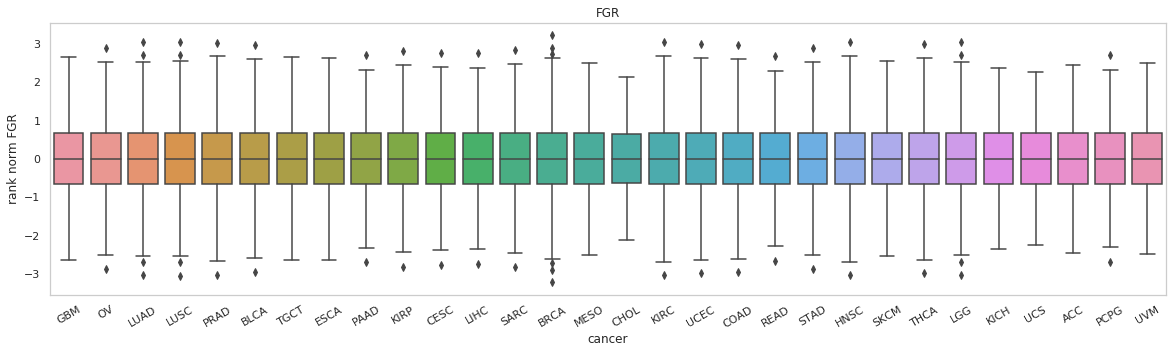

In [123]:
x="FGR"
#plot rna expression by cancer type
sns.set(style="whitegrid", font_scale = 1)
plt.figure(figsize=(20,5))
sns.set_style("whitegrid", {'axes.grid' : False})
ax = sns.boxplot(x="cancer", y=x, data=compiled)
ax.set(xlabel="cancer", ylabel='rank norm FGR')
plt.xticks(rotation=30)
plt.title(x)

In [124]:
del compiled["cancer"]
compiled["IID"]=compiled["FID"]
cols=["FID","IID"]+compiled.columns.tolist()[1:-1]
compiled=compiled[cols]
compiled.columns=[x.replace("-",".") for x in compiled.columns]
compiled=compiled.fillna(-9)

In [126]:
compiled.to_csv(pheno_dir+"pheno_all_zcancer",index=None,sep="\t")

In [125]:
print(compiled.shape)

(8189, 743)


## Get normal phenotype

In [73]:
rna=compile_pancanatlas("/cellar/users/mpagadal/Data/resources/immune-landscape/EBPlusPlusAdjustPANCAN_IlluminaHiSeq_RNASeqV2.geneExp.tsv","normal",pheno[0].tolist())

11A    719
11B     17
11C      1
Name: code, dtype: int64


In [77]:
rna=filter_zeros(rna,0.1)

32 phenotypes with > 0.1 zeroes were removed


In [78]:
print(rna.shape)

(737, 728)


In [79]:
tcga_df=filter_genotyped(rna,"/nrnb/users/mpagadal/tcga-genotypes/imputation/michigan-imputation/HRC/european.final.noimmunecancers.clean.fam")

In [80]:
tcga_df.head()

,FID,PNN,KIF2A,CCR7,MICA,EZR,RND3,CASP1,NOD1,TGFB3,...,FARSB,GLRX3,HCK,NPC2,NRIP3,HERC6,COL16A1,CXCL10,RUVBL1,CD52
0,TCGA-22-4593,803.165,381.743,133.5580,376.557,15622.4,1190.610,1096.220,589.213,837.139,...,891.340,905.863,3508.05,28585.1,120.3320,508.818,674.275,385.3740,874.369,3833.51
1,TCGA-22-4609,1473.110,422.486,122.9050,527.235,20938.9,1022.700,873.952,852.654,318.785,...,491.271,513.268,1098.81,13635.1,22.6955,581.704,579.260,546.4380,465.136,1582.40
2,TCGA-22-5471,1023.970,360.445,62.9281,445.634,21336.9,1565.070,908.390,904.538,405.394,...,478.168,514.127,3162.67,14360.9,28.6815,424.229,428.938,70.6336,891.712,4798.80
3,TCGA-22-5472,1055.590,571.236,70.7317,287.540,13716.1,874.664,1052.260,680.409,1002.550,...,621.722,648.374,3123.73,16557.6,64.5811,554.322,1337.750,186.5680,726.940,3535.56
4,TCGA-22-5478,999.511,486.442,225.3770,183.376,14730.2,1481.560,1154.610,1035.750,224.005,...,459.814,436.205,2334.48,10882.9,26.0790,637.425,393.930,368.6750,486.700,4337.35


### Submit cancer-specific phenos for rank normalizations

In [81]:
canc = pd.read_csv("/nrnb/users/mpagadal/tcga-genotypes/birdseed-processing/gtype.meta", delimiter="\t", header=None)
mp = canc.set_index(2)[0].to_dict()
tcga_df["cancer"]=tcga_df["FID"].map(mp)

In [82]:
pheno_dir="/cellar/users/mpagadal/Data/projects/germline-immune/discovery/phenotypes/processed_phenos/pancanatlas/normal/"

In [83]:
for x in tcga_df["cancer"].unique():
    try:
        nml=tcga_df[tcga_df["cancer"]==x]
        del nml["cancer"]
        nml.to_csv(pheno_dir+"pheno_"+x+".unnorm.csv",index=None,sep="\t")
    except:
        pass

In [84]:
compiled=pd.DataFrame()
for x in tcga_df["cancer"].unique().tolist():
    try:
        df=pd.read_csv(pheno_dir+"pheno_"+x+".rank.csv",delimiter="\t")
        df["cancer"]=x
        compiled=compiled.append(df)
    except:
        pass

### Confirm rank normalization

Text(0.5, 1.0, 'FGR')

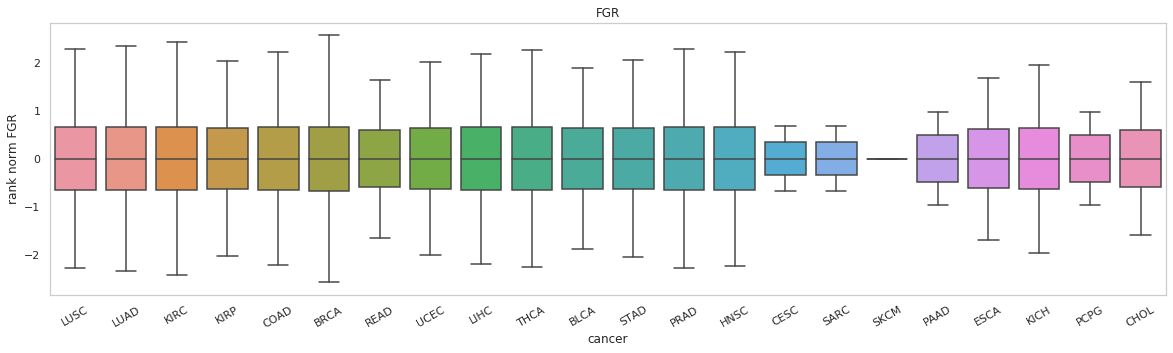

In [85]:
x="FGR"
#plot rna expression by cancer type
sns.set(style="whitegrid", font_scale = 1)
plt.figure(figsize=(20,5))
sns.set_style("whitegrid", {'axes.grid' : False})
ax = sns.boxplot(x="cancer", y=x, data=compiled)
ax.set(xlabel="cancer", ylabel='rank norm FGR')
plt.xticks(rotation=30)
plt.title(x)

In [86]:
del compiled["cancer"]
compiled["IID"]=compiled["FID"]
cols=["FID","IID"]+compiled.columns.tolist()[1:-1]
compiled=compiled[cols]
compiled.columns=[x.replace("-",".") for x in compiled.columns]
compiled=compiled.fillna(-9)

In [87]:
compiled.to_csv(pheno_dir+"pheno_all_zcancer",index=None,sep="\t")

## Get Pearson correlation

In [106]:
fam=pd.read_csv("/nrnb/users/mpagadal/tcga-genotypes/imputation/michigan-imputation/HRC/european.final.noimmunecancers.clean.fam",header=None,sep=" ")

In [107]:
del pheno["IID"]

In [108]:
pheno=pheno.replace(-9, np.nan)

In [109]:
pheno_corr=pheno.corr(method="pearson")

In [110]:
pheno_corr.to_csv("/cellar/users/mpagadal/Data/projects/germline-immune/immune-phenotype-pearson/pancan.immune.phenotypes.pearson.csv")